# SIADS 543 Unsupervised Learning (Week 3): 
# The E-M algorithm, text representations, and topic modeling

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

# Suppress all warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## The Expectation-Maximization algorithm

### Coin-flipping example

#### This code implements the two-coin flipping example in the lecture.

In [2]:
import numpy as np

### This example is based on original code from a University of Michigan EECS 445 tutorial
### by Jake Abernathy and Jia Deng, combined with additional material by Karl Rosaen.

def coin_em(rolls, theta_A=None, theta_B=None, maxiter=10):
    # Initial Guess
    theta_A = theta_A or random.random()
    theta_B = theta_B or random.random()
    thetas = [(theta_A, theta_B)]
    # Iterate
    for c in range(maxiter):
        print("#%d:\t%0.2f %0.2f" % (c, theta_A, theta_B))
        heads_A, tails_A, heads_B, tails_B = e_step(rolls, theta_A, theta_B)
        theta_A, theta_B = m_step(heads_A, tails_A, heads_B, tails_B)
        
    thetas.append((theta_A,theta_B))    
    return thetas, (theta_A,theta_B)

def e_step(rolls, theta_A, theta_B):
    """Produce the expected value for heads_A, tails_A, heads_B, tails_B 
    over the rolls given the coin biases"""
    
    heads_A, tails_A = 0,0
    heads_B, tails_B = 0,0
    for trial in rolls:
        likelihood_A = coin_likelihood(trial, theta_A)
        likelihood_B = coin_likelihood(trial, theta_B)
        p_A = likelihood_A / (likelihood_A + likelihood_B)
        p_B = likelihood_B / (likelihood_A + likelihood_B)
        print ("trial: ", trial)
        print ("p_A: ", p_A)
        print ("p_B: ", p_B)
        print ("Expected Heads_A:", p_A * trial.count("H"))
        print ("Expected Heads_B:", p_B * trial.count("H"))
        
        heads_A += p_A * trial.count("H")
        tails_A += p_A * trial.count("T")
        heads_B += p_B * trial.count("H")
        tails_B += p_B * trial.count("T")
    print("Expected Total Heads A:", heads_A)
    print("Expected Total Heads B:", heads_B)
    return heads_A, tails_A, heads_B, tails_B

def m_step(heads_A, tails_A, heads_B, tails_B):
    """Produce the values for theta that maximize the expected number of heads/tails"""

    # Replace dummy values with your implementation
    theta_A = heads_A / (heads_A + tails_A)
    theta_B = heads_B / (heads_B + tails_B)
    return theta_A, theta_B

def coin_likelihood(roll, bias):
    # P(X | Z, theta)
    numHeads = roll.count("H")
    flips = len(roll)
    return pow(bias, numHeads) * pow(1-bias, flips-numHeads)


#### Running EM with initial guesses for $\theta_A = 0.6$, $\theta_B = 0.5$. It converges after about seven steps.

In [3]:
rolls = [ "HTTTHHTHTH", "HHHHTHHHHH", "HTHHHHHTHH", 
          "HTHTTTHHTT", "THHHTHHHTH" ]
thetas, _ = coin_em(rolls, 0.6, 0.5, maxiter=10)

#0:	0.60 0.50
trial:  HTTTHHTHTH
p_A:  0.44914892610093643
p_B:  0.5508510738990636
Expected Heads_A: 2.245744630504682
Expected Heads_B: 2.754255369495318
trial:  HHHHTHHHHH
p_A:  0.804985517232276
p_B:  0.19501448276772407
Expected Heads_A: 7.244869655090484
Expected Heads_B: 1.7551303449095166
trial:  HTHHHHHTHH
p_A:  0.7334671580091432
p_B:  0.26653284199085686
Expected Heads_A: 5.8677372640731456
Expected Heads_B: 2.132262735926855
trial:  HTHTTTHHTT
p_A:  0.3521561338462594
p_B:  0.6478438661537407
Expected Heads_A: 1.4086245353850375
Expected Heads_B: 2.5913754646149627
trial:  THHHTHHHTH
p_A:  0.6472151158991253
p_B:  0.3527848841008746
Expected Heads_A: 4.530505811293877
Expected Heads_B: 2.4694941887061224
Expected Total Heads A: 21.29748189634723
Expected Total Heads B: 11.702518103652775
#1:	0.71 0.58
trial:  HTTTHHTHTH
p_A:  0.29581932476336203
p_B:  0.704180675236638
Expected Heads_A: 1.4790966238168102
Expected Heads_B: 3.52090337618319
trial:  HHHHTHHHHH
p_A:  0.8115104

#### This code plots EM convergence and a contour map of the likelihood in the parameter space.

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl

def plot_coin_likelihood(rolls, thetas=None):
    # grid
    xvals = np.linspace(0.01,0.99,100)
    yvals = np.linspace(0.01,0.99,100)
    X,Y = np.meshgrid(xvals, yvals)
    
    # compute likelihood
    Z = []
    for i,r in enumerate(X):
        z = []
        for j,c in enumerate(r):
            z.append(coin_marginal_likelihood(rolls,c,Y[i][j]))
        Z.append(z)
    
    # plot
    plt.figure(figsize=(10,8))
    C = plt.contour(X,Y,Z,150)
    cbar = plt.colorbar(C)
    plt.title(r"Likelihood $\log p(\mathcal{X}|\theta_A,\theta_B)$", fontsize=20)
    plt.xlabel(r"$\theta_A$", fontsize=20)
    plt.ylabel(r"$\theta_B$", fontsize=20)
    
    # plot thetas
    if thetas is not None:
        thetas = np.array(thetas)
        plt.plot(thetas[:,0], thetas[:,1], '-k', lw=2.0)
        plt.plot(thetas[:,0], thetas[:,1], 'ok', ms=5.0)
        

def coin_marginal_likelihood(rolls, biasA, biasB):
    # P(X | theta)
    trials = []
    for roll in rolls:
        h = roll.count("H")
        t = roll.count("T")
        likelihoodA = coin_likelihood(roll, biasA)
        likelihoodB = coin_likelihood(roll, biasB)
        trials.append(np.log(0.5 * (likelihoodA + likelihoodB)))
    return sum(trials)

#### The line in the plot connects the starting guess value for the parameters with the final parameter estimate after convergence to a local maximum likelihood solution.

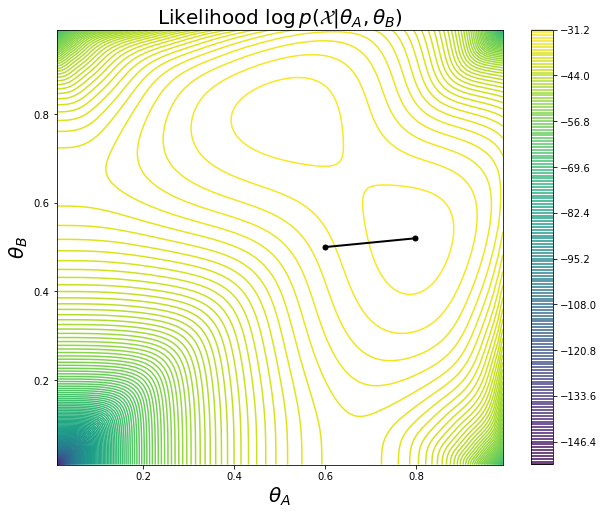

In [5]:
plot_coin_likelihood(rolls, thetas)

#### Re-running EM with different initial guesses for $\theta_A$, $\theta_B$.  Notice how it converges to a different (symmetrical) local maximum

#0:	0.10 0.30
trial:  HTTTHHTHTH
p_A:  0.01425219941348975
p_B:  0.9857478005865102
Expected Heads_A: 0.07126099706744875
Expected Heads_B: 4.928739002932551
trial:  HHHHTHHHHH
p_A:  6.531678641410848e-05
p_B:  0.9999346832135859
Expected Heads_A: 0.0005878510777269764
Expected Heads_B: 8.999412148922273
trial:  HTHHHHHTHH
p_A:  0.00025188916876574334
p_B:  0.9997481108312344
Expected Heads_A: 0.0020151133501259467
Expected Heads_B: 7.997984886649875
trial:  HTHTTTHHTT
p_A:  0.05282183399082202
p_B:  0.9471781660091779
Expected Heads_A: 0.21128733596328808
Expected Heads_B: 3.7887126640367117
trial:  THHHTHHHTH
p_A:  0.0009708737864077679
p_B:  0.9990291262135922
Expected Heads_A: 0.006796116504854376
Expected Heads_B: 6.993203883495145
Expected Total Heads A: 0.29194741396344415
Expected Total Heads B: 32.70805258603656
#1:	0.43 0.66
trial:  HTTTHHTHTH
p_A:  0.6120436607869707
p_B:  0.38795633921302924
Expected Heads_A: 3.0602183039348536
Expected Heads_B: 1.9397816960651462
trial:  H

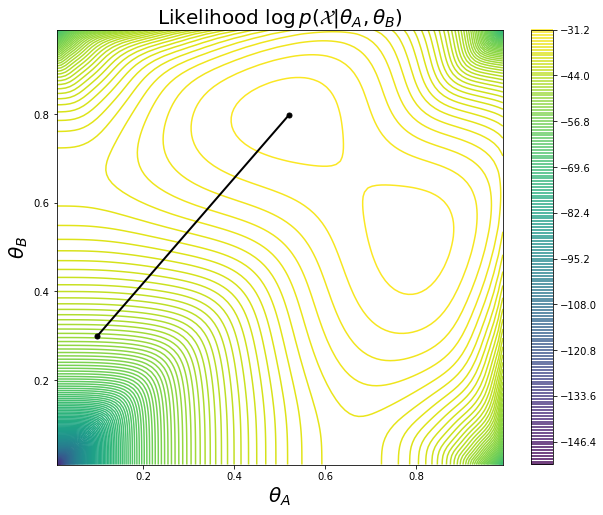

In [6]:
thetas2, _ = coin_em(rolls, 0.1, 0.3, maxiter=10)
plot_coin_likelihood(rolls, thetas2)

In [7]:
#### Example from lecture

rolls = [ "HTHTTHTHTH", "HHHHTHHHHT", "THTTTHTHHT", 
          "HHTHHTHHTH", "HHTHTHHTTT" ]
thetas, _ = coin_em(rolls, 0.2, 0.6, maxiter=10)

#0:	0.20 0.60
trial:  HTHTTHTHTH
p_A:  0.11636363636363642
p_B:  0.8836363636363636
Expected Heads_A: 0.5818181818181821
Expected Heads_B: 4.418181818181818
trial:  HHHHTHHHHT
p_A:  0.0006092916984006098
p_B:  0.9993907083015994
Expected Heads_A: 0.004874333587204878
Expected Heads_B: 7.995125666412795
trial:  THTTTHTHHT
p_A:  0.4413793103448276
p_B:  0.5586206896551723
Expected Heads_A: 1.7655172413793103
Expected Heads_B: 2.2344827586206892
trial:  HHTHHTHHTH
p_A:  0.003644646924829159
p_B:  0.9963553530751708
Expected Heads_A: 0.025512528473804114
Expected Heads_B: 6.974487471526196
trial:  HHTHTHHTTT
p_A:  0.11636363636363642
p_B:  0.8836363636363636
Expected Heads_A: 0.5818181818181821
Expected Heads_B: 4.418181818181818
Expected Total Heads A: 2.9595404670766836
Expected Total Heads B: 26.040459532923318
#1:	0.44 0.60
trial:  HTHTTHTHTH
p_A:  0.5332130679101407
p_B:  0.4667869320898592
Expected Heads_A: 2.6660653395507032
Expected Heads_B: 2.3339346604492963
trial:  HHHHTHHHHT
p_

## Text processing

### Simple corpus example using CountVectorizer

In [8]:
simple_documents_train = ['The cat, dog, and duck were friends. \
                          The cat and duck met at the dog\'s house despite the dog\'s objections.', 
                   'Computers have power supplies that regulate power consumption.', 
                   'Plug in the monitor and turn on the computer. \
                     the monitor is now ready for use.', 
                   'You will find the plug on the right side of the screen.', 
                   'My friend likes coffee and cats.', 
                   'His dog gets along well with my friend.']

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

tf_vectorizer = CountVectorizer(stop_words='english')
tf_documents = tf_vectorizer.fit_transform(simple_documents_train)

print("doc-term matrix shape:", tf_documents.shape)
print("doc-term matrix initial row (first document vector):\n", 
      tf_documents[0:1] )

doc-term matrix shape: (6, 26)
doc-term matrix initial row (first document vector):
   (0, 0)	2
  (0, 7)	3
  (0, 8)	2
  (0, 10)	1
  (0, 14)	1
  (0, 12)	1
  (0, 6)	1
  (0, 16)	1


In [10]:
### How many unique terms in the vocabulary?
tf_feature_names = tf_vectorizer.get_feature_names()
vocab = tf_vectorizer.vocabulary_

print("Number of unique terms in vocabulary:", len(tf_feature_names))
print("And here are the terms:\n")
for i in range(0, len(tf_feature_names)):
    print(tf_feature_names[i])

### Which column corresponds to a given term? 
### Remember that the first column index is zero.
print("The term frequency of \'cats' can be found in column", 
      vocab["cats"])
print("The term frequency of \'monitor' can be found in column", 
      vocab["monitor"])


Number of unique terms in vocabulary: 26
And here are the terms:

cat
cats
coffee
computer
computers
consumption
despite
dog
duck
friend
friends
gets
house
likes
met
monitor
objections
plug
power
ready
regulate
right
screen
supplies
turn
use
The term frequency of 'cats' can be found in column 1
The term frequency of 'monitor' can be found in column 15


### More realistic example using newsgroups collection, tf.idf weighting, and specific text processing options

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import pickle

# This code will take a minute or two to load and process the dataset...

pickle_in = open("20newsgroups_train_data.pickle", "rb")
documents_train = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open("20newsgroups_train_labels.pickle", "rb")
labels_train = pickle.load(pickle_in)
pickle_in.close()



# TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features = 10000, # only top 10k by freq
                                   lowercase = False, # keep capitalization
                                   ngram_range = (1,2), # include 2-word phrases
                                   min_df=10,  # note: absolute count of doc
                                   max_df=0.95,   # note: % of docs
                                   stop_words='english') # default English stopwords

tfidf_documents = tfidf_vectorizer.fit_transform(documents_train)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# CountVectorizer
tf_vectorizer = CountVectorizer(max_features = 10000, # only top 10k by freq
                                   lowercase = False, # keep capitalization
                                   ngram_range = (1,2), # include 2-word phrases
                                   min_df=10,  # note: absolute count of doc
                                   max_df=0.95,   # note: % of docs
                                   stop_words='english') # default English stopwords

tf_documents = tf_vectorizer.fit_transform(documents_train)

In [12]:
### How many unique terms in the vocabulary?
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
vocab = tfidf_vectorizer.vocabulary_

print("Number of unique terms in vocabulary:", len(tfidf_feature_names))
print("Sample terms:")
for i in range(5050, 5060):
    print(tfidf_feature_names[i])
print("doc-term matrix initial row (first document vector):\n", 
      tfidf_documents[0:1] )

Number of unique terms in vocabulary: 10000
Sample terms:
deficit
definately
define
defined
defines
defining
definite
definitely
definition
definitions
doc-term matrix initial row (first document vector):
   (0, 1795)	0.17314794732264205
  (0, 1858)	0.20858842142487943
  (0, 7012)	0.11412930945675137
  (0, 6970)	0.1195521604813801
  (0, 6489)	0.1331713376929164
  (0, 6280)	0.14196861393206175
  (0, 8019)	0.1812899909419918
  (0, 9982)	0.10526966743951179
  (0, 8973)	0.18442892557515514
  (0, 5523)	0.16194450739981905
  (0, 7238)	0.1516987121760619
  (0, 1765)	0.07683851052951017
  (0, 6735)	0.07758885622623042
  (0, 3233)	0.08335263451581146
  (0, 4219)	0.14508229012867038
  (0, 8443)	0.1362914699751043
  (0, 8721)	0.16307743189509888
  (0, 4309)	0.21861271135962404
  (0, 3708)	0.1566613149369307
  (0, 1794)	0.09305750896721526
  (0, 8884)	0.12700115215388127
  (0, 8237)	0.10144529382754937
  (0, 5340)	0.19253046296918727
  (0, 3151)	0.061274346944318644
  (0, 4349)	0.11768303950174278

## Latent Semantic Indexing

### Example showing how to perform LSI (on the newsgroup dataset)

In [13]:
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# We use the variable that holds the newsgroup corpus that we loaded earlier.
# Initialize the TfidfVectorizer we want for this LSI example
tfidf_vectorizer = TfidfVectorizer(ngram_range = (1,1), 
                                   min_df=2,  
                                   max_df=0.95,  
                                   stop_words='english') # default English stopwords

tfidf_documents = tfidf_vectorizer.fit_transform(documents_train)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LSI does truncated SVD on the document-term matrix of tf.idf term-weights.
# The matrix we got back from the vectorizer is a 
# document-term matrix, i.e. one row per document.
# To match the examples and development of LSI in 
# our lectures, we're going to 
# take the transpose of the document-term matrix to give 
# TruncatedSVD the term-document matrix as input.
n_topics = 200
lsi = TruncatedSVD(n_components=n_topics, random_state=0)

# This is the matrix U_k:  num_term_features x num_topics
reduced_term_matrix = lsi.fit_transform(np.transpose(tfidf_documents)) 

# and this is the matrix V_k^T  num_topics x num_documents
reduced_document_matrix = lsi.components_

# these are the the values along the diagonal of matrix \Sigma.
singular_values = lsi.singular_values_

print(len(documents_train))
print(tfidf_documents.shape)
print(reduced_term_matrix.shape)
print(lsi.components_.shape)
print(lsi.singular_values_.shape)

11311
(11311, 38328)
(38328, 200)
(200, 11311)
(200,)


## Latent Dirichlet Allocation

#### These tf.idf and tf vectorizers will be used in several places later on.

In [14]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_documents = tfidf_vectorizer.fit_transform(documents_train)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

tf_vectorizer = CountVectorizer(stop_words='english')
tf_documents = tf_vectorizer.fit_transform(documents_train)
tf_feature_names = tf_vectorizer.get_feature_names()

print(tf_documents.shape)

(11311, 89428)


In [15]:
n_topics = 10

from sklearn.decomposition import LatentDirichletAllocation

# This will take a couple of minutes to run...

lda = LatentDirichletAllocation(n_components = n_topics, random_state=0)
lda.fit(tf_documents)
topic_models = lda.components_

In [16]:
num_top_words = 8

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        term_list = [feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        print("topic %d:" % (topic_idx), term_list)


display_topics(lda, tf_feature_names, num_top_words)

topic 0: ['game', '00', 'team', 'year', 'games', '25', 'season', 'players']
topic 1: ['ax', 'max', 'g9v', 'b8f', 'a86', 'pl', '145', '1d9']
topic 2: ['gun', 'mr', 'stephanopoulos', 'bike', 'president', '000', 'guns', 'cx']
topic 3: ['space', 'file', 'db', 'program', 'entry', '1993', 'nasa', 'use']
topic 4: ['people', 'don', 'think', 'just', 'know', 'like', 'god', 'time']
topic 5: ['key', 'encryption', '10', 'chip', 'use', 'keys', 'clipper', 'information']
topic 6: ['00', '50', 'atheism', '10', 'atheists', 'new', 'good', 'atheist']
topic 7: ['like', 'use', 'know', 'just', 'windows', 'drive', 'does', 'thanks']
topic 8: ['window', 'w7', 'widget', 'uw', 't7', 'chz', 'application', 'cx']
topic 9: ['edu', 'com', 'available', 'ftp', 'file', 'mail', 'image', 'server']


In [17]:
# Use transform on the original document-term matrix 
# to get the document weights per topic
lda_output = lda.transform(tf_documents)
print("LDA transform output:\n", lda_output)
best_document_per_topic = np.argsort(lda_output, axis = 0)[::-1]
for topic_index in range(0, 10):
    best_index = best_document_per_topic[0, topic_index]
    print("Highest topic", topic_index, "weight is document", 
          best_index, ":", documents_train[best_index][0:20])

LDA transform output:
 [[1.31533797e-01 2.63157897e-03 2.63204819e-03 ... 5.57104832e-01
  5.73100302e-02 2.63193405e-03]
 [2.00018497e-03 2.00000196e-03 2.00037329e-03 ... 6.44266304e-01
  2.00022497e-03 1.67701525e-01]
 [6.62541769e-04 6.62251721e-04 2.08549119e-02 ... 6.82104720e-01
  6.62284660e-04 6.62386441e-04]
 ...
 [1.06343485e-01 2.04083722e-03 2.04150866e-03 ... 7.80408515e-01
  2.04103794e-03 2.04149022e-03]
 [4.00054918e-03 4.00000002e-03 4.00130975e-03 ... 2.65433439e-01
  4.00032953e-03 4.00061752e-03]
 [3.49563852e-01 2.70274438e-03 3.59906336e-01 ... 2.71607154e-01
  2.70305162e-03 2.70310666e-03]]
Highest topic 0 weight is document 1583 : I'm looking to find 
Highest topic 1 weight is document 4771 : 
------------ Part 1
Highest topic 2 weight is document 7066 : :>Top Ten Ways Slick
Highest topic 3 weight is document 1703 : We have received a n
Highest topic 4 weight is document 1291 : Accounts of Anti-Arm
Highest topic 5 weight is document 9005 : I saw this article p

### Example using the pyLDAvis package

In [18]:
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda, tf_documents, tf_vectorizer, mds='tsne')
panel

/opt/conda/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:169: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifi

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
4      32.420952   8.115230       1        1  32.618228
7       0.648955  71.707100       2        1  15.171748
9      71.019684   9.971006       3        1  10.412508
3       3.785981  33.185135       4        1   9.579053
1     -42.666500  -9.222070       5        1   9.367524
5      -3.621689 -43.526516       6        1   6.995863
8      -3.632402  -4.171708       7        1   4.919587
0     -36.584400  35.804413       8        1   4.882423
2      44.391380  50.615383       9        1   4.021579
6      40.235809 -31.591665      10        1   2.031487, topic_info=          Term          Freq         Total Category  logprob  loglift
17209       ax  58233.000000  58233.000000  Default  30.0000  30.0000
52547      max   4281.000000   4281.000000  Default  29.0000  29.0000
31598      edu   2277.000000   2277.000000  Default  28.0000  28.0000
37128      g9v   1089.000000   1089.000000  Default  27.0000  27.0000
47281      key   1101.000000   1101.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
38426      god     44.827257   1913.311384  Topic10  -6.2979   0.1426
9964        80     38.473338    428.158707  Topic10  -6.4508   1.4869
23168   church     36.904402    443.465629  Topic10  -6.4924   1.4101
71133  science     36.327331    438.615140  Topic10  -6.5082   1.4054
9361        75     35.670905    316.102411  Topic10  -6.5264   1.7147

[753 rows x 6 columns], token_table=       Topic      Freq   Term
term                         
0          1  0.005777     00
0          2  0.038510     00
0          3  0.020218     00
0          4  0.049101     00
0          6  0.120344     00
...      ...       ...    ...
88193      9  0.025139  years
88193     10  0.006094  years
88409     10  0.903259  yount
89365      7  0.934724     zv
89365      9  0.055804     zv

[2358 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 8, 10, 4, 2, 6, 9, 1, 3, 7])

## Non-negative Matrix Factorization (NMF)

In [19]:
n_topics = 10
X = tfidf_documents

from sklearn import decomposition

nmf = decomposition.NMF(n_components=n_topics, random_state=0, init="nndsvd")
W = nmf.fit_transform(X) 
H = nmf.components_

top = 8
topic_index_max = n_topics

for topic_index in range(0, topic_index_max):
    top_indices = np.argsort(H[topic_index, :])[::-1]
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append(tfidf_feature_names[term_index])
    print("topic ", topic_index, top_terms)

topic  0 ['don', 'just', 'like', 'think', 'know', 'good', 've', 'time']
topic  1 ['windows', 'file', 'dos', 'window', 'files', 'program', 'use', 'using']
topic  2 ['god', 'jesus', 'bible', 'believe', 'faith', 'christ', 'christian', 'christians']
topic  3 ['geb', 'dsl', 'chastity', 'n3jxp', 'pitt', 'cadre', 'shameful', 'intellect']
topic  4 ['key', 'chip', 'encryption', 'clipper', 'keys', 'government', 'escrow', 'algorithm']
topic  5 ['drive', 'scsi', 'disk', 'drives', 'ide', 'hard', 'controller', 'floppy']
topic  6 ['game', 'team', 'games', 'year', 'players', 'season', 'play', 'hockey']
topic  7 ['thanks', 'does', 'mail', 'know', 'advance', 'hi', 'info', 'looking']
topic  8 ['people', 'israel', 'government', 'armenian', 'jews', 'israeli', 'armenians', 'state']
topic  9 ['card', 'video', 'monitor', 'vga', 'bus', '00', 'cards', 'color']


#### We'll display the weights for topic 1 below.

/opt/conda/lib/python3.8/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/opt/conda/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


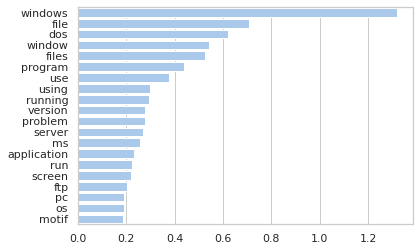

In [20]:
%matplotlib inline
import seaborn as sns

import matplotlib.pyplot as plt
sns.set(style="whitegrid")

topic_index = 1
vocab = np.array(tfidf_feature_names)
top_term_indices = np.array(np.argsort(H[topic_index, :])[::-1])[0:20]

term_strings = vocab[top_term_indices]
term_weights = H[topic_index, top_term_indices]

sns.set_color_codes("pastel")
sns.barplot(x=term_weights, y=term_strings, label="Weight", color="b")

plt.show()

#### Now find the top two most representative documents for each NMF topic

In [21]:
top_docs = 2
for topic_index in range(0,10):
    top_indices = np.argsort(W[:, topic_index])[::-1]
    top_documents = []
    for doc_index in top_indices[0:top_docs]:
        doc = documents_train[doc_index]
        print(topic_index, doc_index, doc[0:40].replace("\n", ""))
        top_documents.append(doc)

0 1532 **************  This is somewhat long, 
0 2553 *nnnnnnnng* Thank you for playing, I c
1 2139 In comp.os.ms-windows.misc you write:
1 2390 I quit windows normally to run a special
2 5557 I have come across what I consider to be
2 10192 [deleted]think:[deleted]             
3 8548 So just what was it you wanted to say?
3 8658 By law, they would not be allowed to d
4 5896 Here is a revised version of my summary 
4 8443 It looks like Dorothy Denning's wrong-he
5 7720 : >>point of view, why does SCSI have an
5 3724 I have a 486sx25 computer with a 105 Mg 
6 9633 Archive-name: hockey-faqrec.sport.hock
6 6148 Not clear to me at all.  I'd certainly 
7 8569 Hi,	Does anyone know anything about thi
7 4695    does anyone have the e-mail address
8 70 : Pardon me? Here is to an amherst-clow
8 3753 Center for Policy Research writes...
9 764 I have a Radius Precision Color 24x vide
9 8742 To those interested in the new ATI Ultra


## Word embedding: word2vec

#### We'll re-introduce this silly little corpus just to show how context can influence the results of word2vec. There are two distinct types of document here: ones that mention animals, and ones that mention computers.

In [22]:
simple_documents_train = ['The cat dog and duck were friends. \
                          The cat and duck met at the dog house despite objections from the dog', 
                   'My computer has a power supply that regulates power consumption.', 
                   'Plug in the monitor and turn on the computer and \
                     the monitor is now ready for use.', 
                   'You will find the plug on the right side of the screen', 
                   'My friend likes coffee and her cat and her duck', 
                   'His dog gets along well with my friend']

#### Now use the W2VTransformer class from gensim to compute the word2vec embedding
#### using our silly corpus as the training set.

In [23]:
from gensim.sklearn_api import W2VTransformer

# Create a model to represent each word by a 10 dimensional vector.
model = W2VTransformer(size=10, min_count=1, seed=2)

# Parse the silly documents into a form W2VTransformer wants:
# Each document is a list of strings (words)
simple_corpus = []
for i in range(len(simple_documents_train)):
    t = simple_documents_train[i].lower().split(' ')
    simple_corpus.append(t)
    
# Now fit the word2vec model with the corpus, and use the fit model
# to embed the given  words into a 10-dimensional space
embed_words = ['cat', 'dog', 'duck', 'supply', 'friend', 'power', 'computer', 'plug', 'screen']
wordvecs = model.fit(simple_corpus).transform(embed_words)


def dump_word_embeddings(words, wordvecs):
    for i in range(0, len(words)):
        print(words[i], "\t", wordvecs[i]) 

/opt/conda/lib/python3.8/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [24]:
dump_word_embeddings(embed_words, wordvecs)

cat 	 [-0.04389895 -0.0302579  -0.04134555  0.04150729  0.00811414  0.03355613
  0.03692827  0.02695047 -0.02365173 -0.03968875]
dog 	 [-0.0017036  -0.03165774 -0.00439001 -0.03306147  0.02253429  0.03790338
 -0.02973379 -0.04264131  0.00811525 -0.02190416]
duck 	 [-0.00312961  0.04352603  0.03688039 -0.03224256 -0.03799621 -0.04017409
  0.00065623  0.00732231 -0.0071363   0.04615823]
supply 	 [ 0.00696942  0.04526414 -0.03409897  0.01546267  0.03892093  0.00765697
 -0.03675239  0.00336699 -0.04002248 -0.04941249]
friend 	 [-0.00523201  0.01474939 -0.02439254 -0.0260576  -0.04355735  0.04452503
 -0.04245656 -0.01728226 -0.0359751  -0.00839695]
power 	 [-0.02377325  0.04041952  0.0444893  -0.04061703  0.01380894  0.02476178
 -0.02628935  0.02931613  0.03810706  0.04743228]
computer 	 [ 0.03061536  0.02078598 -0.04659361 -0.03322293 -0.0395672  -0.03335822
  0.01810896 -0.01261963  0.01823996 -0.04547044]
plug 	 [ 0.02396038  0.0176496   0.02908412 -0.04465587 -0.00052106  0.01166581
 -0

In [25]:
### Feel free to use this routine to plot your own word embedding results!
def plot_word_embedding_vectors(embedding_vectors, labels):
    coeff = embedding_vectors
    pca1=0
    pca2=1
    n = coeff.shape[0]
    zoom = 2.0 * np.max(coeff)
    width = 2.0 * zoom
    scalex =  width/2
    scaley =  width/2
    text_scale_factor = 1.3
        
    fig = plt.gcf()
    fig.set_size_inches(7, 7)
    
    #plt.scatter(xs*scalex, ys*scaley, s=9)
    for i in range(n):
        plt.plot(0, 0, coeff[i,pca1], coeff[i,pca2], color='b',alpha=0.9) #, head_width = 0.03 * zoom) 
        if labels is None:
            plt.text(coeff[i,pca1]* text_scale_factor, 
                     coeff[i,pca2] * text_scale_factor, 
                     "Var"+str(i+1), color='g', ha='center', va='center')
        else:
            plt.text(coeff[i,pca1]* text_scale_factor, 
                     coeff[i,pca2] * text_scale_factor, 
                     labels[i], color='g', ha='center', va='center')
    
    plt.xlim(-zoom,zoom)
    plt.ylim(-zoom,zoom)
    plt.grid()

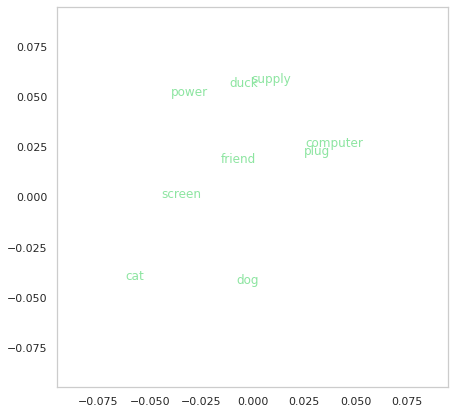

In [26]:
plot_word_embedding_vectors(wordvecs, embed_words)

#### We're going to use Multi-Dimensional Scaling to reduce from 10 dimensions to 2, preserving distances between words as they were expressed in the 10-d embedding space.  Then plot it.

/opt/conda/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:56: D

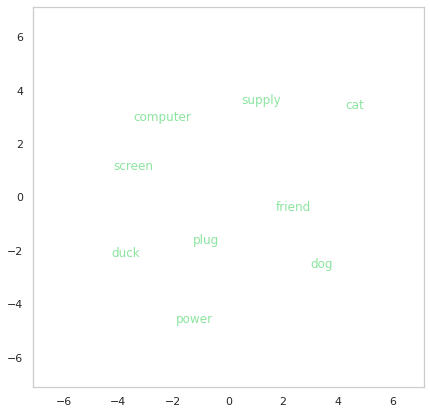

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS

X_embed_normalized = StandardScaler().fit(wordvecs).transform(wordvecs)  

mds = MDS(n_components = 2, random_state = 0)
X_embed_mds = mds.fit_transform(X_embed_normalized)
plot_word_embedding_vectors(X_embed_mds, np.transpose(embed_words))

In [28]:
import pickle 

# do some magic here to open the large embedding model using the correct path
from os import getenv
from pathlib import Path

is_coursera = getenv("WORKSPACE_TYPE")
path = Path().resolve().parent.joinpath("assignments")
if is_coursera is None: path = path.joinpath("source")
embedding_file = path.joinpath("assignment3/assets/text8_W2V.pickle")


# This will likely take several minutes to run if uncommented...
# Not supported within the Coursera environment since it uses
# external downloading via http.
#
# import gensim.downloader as api
# corpus = api.load('text8')
# text8_model = W2VTransformer(size=100, min_count=1, seed=2)
# text8_model.fit(corpus)
#
# So we load a pre-computed version of the model that was created with
# the above code and stored in a (large!) pickle file.
# print(embedding_file)
f = open(embedding_file, "rb")
text8_model = pickle.load(f)
f.close()

In [29]:
# Now we're going to compute word embedding vectors for the
# same set of terms as before, but using a word2vec embedding
# trained on a more significant corpus. This gives many more context
# observations for the terms and thus should result in a better-quality
# embedding.  For example, "duck" is now grouped with the other animals.

/opt/conda/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:56: D

[[  3.81083733   1.27219201]
 [  9.65170297  -0.50662521]
 [  4.64739641  -3.07218715]
 [-10.46194572   2.12423654]
 [  7.65993131  10.59003206]
 [ -7.77821052  10.2682081 ]
 [  1.06469847 -12.99067975]
 [ -2.59558536  -0.63820692]
 [ -5.99882488  -7.04696968]]


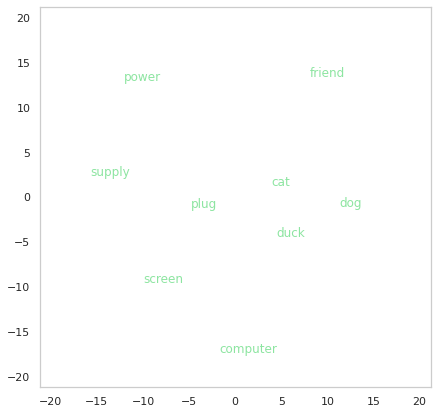

In [30]:
text8_wordvecs = text8_model.transform(embed_words)
X_embed_normalized = StandardScaler().fit(text8_wordvecs).transform(text8_wordvecs)  

mds = MDS(n_components = 2, random_state = 42)
X_embed_mds = mds.fit_transform(X_embed_normalized)
plot_word_embedding_vectors(X_embed_mds, np.transpose(embed_words))
print (X_embed_mds)

/opt/conda/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:56: D

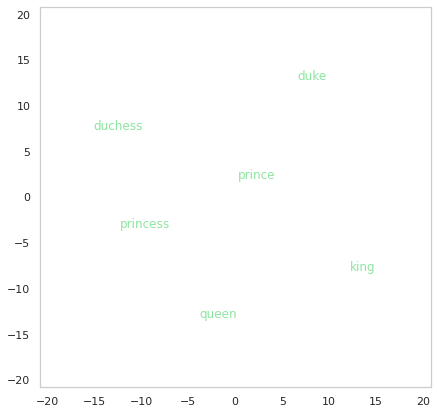

In [31]:
# Now we're going to give an example of the linear relations
# found between analogous words. You should see how the direction and distance
# of the vector from king is to queen is roughly the same as prince to princess
# and duke to duchess.  Several papers have attempted to explain this phenomenon
# e.g. see "Toward Understanding Linear Word Analogies" by
# Ethayarajh, Duvenaud, and Hirst. https://www.aclweb.org/anthology/P19-1315.pdf

def plot_words(word_list):
    text8_wordvecs = text8_model.transform(word_list)
    X_embed_normalized = StandardScaler().fit(text8_wordvecs).transform(text8_wordvecs)  

    mds = MDS(n_components = 2, random_state = 42)
    X_embed_mds = mds.fit_transform(X_embed_normalized)
    plot_word_embedding_vectors(X_embed_mds, np.transpose(word_list))
    
plot_words(["king", "queen", "duke", "duchess", "prince", "princess"])